3/10/24

In [2]:
import torch
import torch.nn as nn
from torch.nn.functional import relu

from torchvision import transforms
from PIL import Image



U-Net architecture attached below
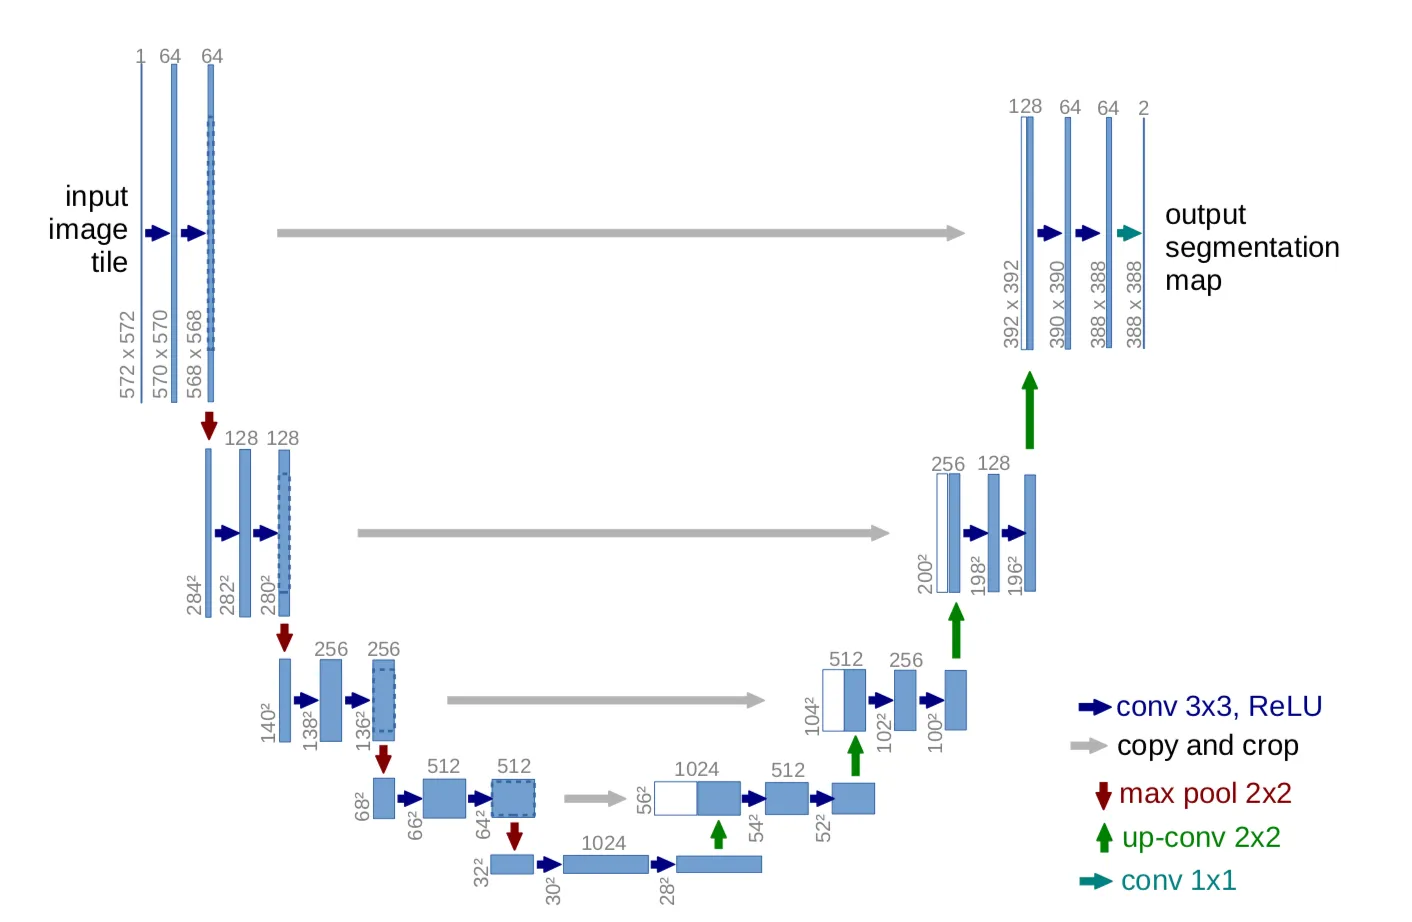

In [ ]:
class unet(nn.Module):
    def __init__(self, nClasses):
        super().__init__()

        #Source - https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
        #nClasses = 1024 x 256 = 262,144 based on 264,144 inputs for unscaled images
        #nClasses = 1024 x 256 = 262,144 based on 64 x 16 = 1,024 for scaled images 
        #1024x256 input size
        #self.ENCODER/DECODER-ROW-LAYER -> self.e11 means Encoder Row 1 Layer 1
        #self.POOLn -> max pooling layer of row n - self.pool1 pools the feature maps of row 1 for row 2
        #convolution calculater - https://madebyollin.github.io/convnet-calculator/
        #in channels is one because input image has been converted to greyscale on import to dataloader
        self.e11 = nn.Conv2d(in_channels= 1, out_channels= 64, kernel_size= 3, padding= 1) #1022x254x64
        self.e12 = nn.Conv2d(64, 64, 3, padding=1) #1020x252x64
        self.pool1 = nn.MaxPool2d(kernel_size= 2, stride= 2) #510x126x64

        self.e21 = nn.Conv2d(64, 128, 3, padding=1) #508x63x128
        self.e22 = nn.Conv2d(128, 128, 3, padding=1) #506x61x128
        self.pool2 = nn.MaxPool2d(2, 2, ceil_mode= True) #same as previous max pooling layer but I'm making it explicit in case we change it later... 
        #ceil mode added to get output to be expected 253x(62/2)x128 shape

        self.e31 = nn.Conv2d(128, 256, 3, padding= 1) #251x29x256
        self.e32 = nn.Conv2d(256, 256, 3, padding=1) #249x27x256
        self.pool3 = nn.MaxPool2d(2, 2, ceil_mode=True) #125x14x256

        self.e41 = nn.Conv2d(256, 512, 3, padding=1) #123x12x512
        self.e42 = nn.Conv2d(512, 512, 3, padding=1) #121x10x512
        self.pool4 = nn.MaxPool2d(2, 2, ceil_mode=True) #61x5x512

        self.e51 = nn.Conv2d(512, 1024, 3, padding=1) #59x3x512
        self.e52 = nn.Conv2d(1024, 1024, 3, padding=1) #57x1x512 

        self.upconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2) 
        self.d11 = nn.Conv2d(1024, 512, 3, padding=1)
        self.d12 = nn.Conv2d(512, 512, 3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, nClasses, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out




 